In [226]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from time import sleep

In [234]:
import re
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [228]:
from scipy.sparse.linalg import svds
from numpy import argsort
from numpy import diag

In [229]:
from numpy.linalg import norm
from numpy import zeros
from  numpy import ndarray

In [230]:
from scipy.sparse import save_npz, load_npz
from pickle import load, dump

In [261]:
from bokeh.layouts import row, Spacer

In [231]:
from sklearn.manifold import TSNE
from bokeh.io import output_file,  output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import Circle, HoverTool

from numpy import eye, vstack

### 1. Парсинг данных
Каждое обращение на сайте Роспотребнадзора публикуется на отедльной странице с адресом http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/{НОМЕР_ОБРАЩЕНИЯ}. Нумерация обращений последовательная, поэтому чтобы собрать датасет, по очереди обходим все страницы (на 19.10.2019 последняя имеет порядковый номер 12739). На каждой странице собираем текст обращения, ответ на него и даты из публикации.

In [6]:
def scrape(out_file: str):
    df = pd.DataFrame(columns=('number', 'appeal', 'appeal_date', 'response', 'response_date'))
    log = []
    for page_num in range(6365, 12739):
        try:
            url = f'http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/{page_num}'
            page = requests.get(url)
            if page.url == url:
                soup = BeautifulSoup(page.text, 'html.parser')
                appeal =soup.find('p', attrs={'class': "appeal-details-message"}).text
                appeal_date = soup.find('p', attrs={'class': "appeal-element-bottom"}).text
                response = soup.find('p', attrs={'class': "appeal-comments-message"}).text
                response_date = soup.find('p', attrs={'class': "appeal-comments-date"}).text
                case = {'number': page_num,
                        'appeal': appeal,
                        'appeal_date': appeal_date,
                        'response': response,
                        'response_date': response_date}
                df = df.append(case, ignore_index=True)
                print(page_num)
            else:
                print('missed')
        except Exception as err:
            log.append((page_num, err))
        sleep(0.5)
    df.to_csv(out_file)

При последующих запусках читаем сохраненные данные из RPNfull.csv (есть в репозитории).

In [71]:
df = pd.read_csv('RPNfull.csv')

### 2. Preprocessing

В ходе предобработки оставляем только символы-буквы, удаляем лишние пробелы и разбиваем текст на слова. Далее производим лемматизацию (приведение к начальной форме) слов очищенного текста, используя https://github.com/nlpub/pymystem3.
Возвращаем строку из начальных форм.

In [235]:
stemmer = Mystem()
def preprocess(text):
    # strip all non-alphabetical characaters
    text = re.sub('[^А-яA-z]', ' ', text)
    new_text = []
    for char in range(len(text)):
        if (text[char] == ' ') and (text[char-1] == ' '):
            pass
        else:
            new_text.append(text[char])
    text = ''.join(new_text)
    # tokenize and lemmatize
    tokens = [word for word in stemmer.lemmatize(text) if ((word != ' ') and (word != ' \n'))]
    return ' '.join(tokens)

Также на этапе предобработки определим список стоп-слов, которые будут пропускаться при построении модели и сборе словаря, перечня используемых слов. Дполним стандартный список из nltk.corpus.stopwords.words('russian'). Во-первых, внесем стоп-слова, определенные при первых запусках векторизации текстов (см. изображение ниже). Во-вторых, расширим список словами, которые встречались более, чем в половине определенных на ранних итерациях работы над проектом топиках.

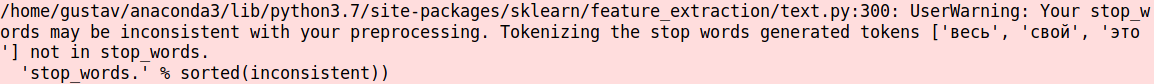

In [9]:
# download nltk stopwords for Russian language
upd_stopwords = stopwords.words('russian')
# stop words defined by vectorizer
upd_stopwords.extend(['весь', 'свой', 'это'])
# stop words defined after topic analysis
upd_stopwords.extend(['год', 'день', 'который'])
upd_stopwords.extend(['дом', 'сказать'])
print(upd_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

### 3. Vectorization

Перейдем к векторизации текстов. Инициализируем векторизатор с помощью опредленных ранее предобработки и стоп-слов. Применим его мтеод fit_transform на копусе из текстов обращений или загрузим сохраненную матрицу векотрных представлений текстов.

In [9]:
try:
    matrix = load_npz('matrix.npz')
except IOError:
    # vectorize the corpus, df.appeal
    counter = CountVectorizer(preprocessor=preprocess, stop_words=upd_stopwords)
    # save the matrix
    matrix = counter.fit_transform(list(df.appeal))
    save_npz('matrix.npz', matrix)
    # save the vectorizer
    with open('vectorizer.pickle', 'xb') as f:
        dump(counter, f)

Подсчитаем втречаемость слов в корпусе. Сохраним в словарь пары слов-встречаемость.

In [13]:
# count word occurencies
wordcounts = matrix.sum(axis=0)
wordcounts = wordcounts.tolist()[0]
wordcounts = [(key, wordcounts[number]) for key, number in counter.vocabulary_.items()]
wordcounts.sort(key=lambda x: x[1], reverse=True)

In [14]:
wordcounts[:15]

[('магазин', 7130),
 ('товар', 6136),
 ('данный', 4703),
 ('телефон', 4006),
 ('деньги', 3969),
 ('просить', 3932),
 ('услуга', 3621),
 ('договор', 3591),
 ('мочь', 3546),
 ('адрес', 3232),
 ('вернуть', 3099),
 ('возврат', 3098),
 ('обращаться', 2824),
 ('добрый', 2773),
 ('компания', 2769)]

"Перевернем" стандартный словарь-атрибут counter.vocabulary_, чтобы можно было искать слова по их позиции в векторе.

In [242]:
# make words searchable by their position in the dictionary
my_vocab = {number: word for word, number in counter.vocabulary_.items()}

### 4. LSI (Latent Symantic Analysis) with SVD

Одним из заданий работы было провести Latent Symantic Analysis и провести моделирование топиков (тем) корпуса текстов обращений в Роспотребнадзор.
Используем для этого функцию scipy.sparse.linalg.svds(), выполняющую SVD-разложение разряженных матриц. Предварительно определим количество сингулярных значений, а значит топиков как 20.

In [10]:
# svd-decompose the wordcount matrix to retrieve prevalent word combintaions aka topics
U, S, VT = svds(matrix.asfptype(), k=20)

In [240]:
# multiply S with VT
SVT = diag(S) @ VT

Для полученных топиков выведем входящие в них слова с весами. 

ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ТОПИКАМ: Не все полученные топики одинаково хорошо поддаются интерпретации: использование SVD -- достаточно искусcтвенный прием для тематического моделирования.
Приведем наиболее удачные, однородные примеры: перевозки, коммунальное хозяйство, элементы ссылок. Особенно иллюстративен пример ссылок: их составные части повторяются из текста в текст и оказались в одном топике.

In [243]:
# represent the topics as the words they consist of
topics = []
i = 0
for row in argsort(VT, axis=1):
    topics.append([(SVT[i][word], my_vocab[word]) for word in row[-10:]])
    i += 1
print(topics[4], end='\n\n')
print(topics[11], end='\n\n')
print(topics[15], end='\n\n')

[(8.29813116558858, 'гарантийный'), (8.5231242357904, 'компания'), (9.591530575316202, 'срок'), (11.653951272453314, 'сервисный'), (12.751398751563784, 'центр'), (14.8692445122276, 'возврат'), (19.63950933081758, 'денежный'), (24.6508619246089, 'средство'), (24.97227817480451, 'ремонт'), (39.56218109925719, 'данный')]

[(8.387650438446727, 'тариф'), (8.813855844237116, 'оказание'), (8.997388194212322, 'телефон'), (12.311333770465593, 'оператор'), (13.111039257445444, 'руб'), (13.887964210548102, 'связь'), (18.18182453078491, 'интернет'), (35.54151329941684, 'договор'), (41.82877895250325, 'магазин'), (59.48256341641661, 'услуга')]

[(15.710986381619938, 'продукт'), (16.257553511082705, 'документ'), (18.21734441431395, 'деньги'), (18.91605929323902, 'просить'), (21.394637746483543, 'обработка'), (26.516791631170626, 'человек'), (28.685857563067, 'кафе'), (31.32126240754412, 'санитарный'), (33.139361065043865, 'магазин'), (37.69564940627271, 'телефон')]



Напишем функции для представления текста как набора тем.

- text_as_topics() векторизует текст ортогонально проецирует полученный вектор на подпространство натянутое на вектора-темы. Эти вектора ортогональны, но не являются базисом для полученного пространтсва, поэтому при проекцировании возможны некоторые потери. Теперь мы можем определить присутствие найденных тем в любом тексте, а не только в тексте из корпуса. Это может быть полезно для обработки новых текстов без перестраивания модели.

- show_topics() просто выводит на экран слова тем, наиболее значимых в данном тексте. 

In [19]:
def text_as_topics(text: str, vectorizer: CountVectorizer, SVT: ndarray) -> ndarray:
    
    """Compute approximate topic representation for the text"""
    
    coefficients = zeros((len(SVT), 1))
    # vectorize text
    vector = counter.transform([text])
    # project text onto the topics from SVT
    for row in range(len(SVT)):
        projection = vector @ SVT[row].reshape(-1, 1) / norm(SVT[row], ord=1)
        coefficients[row, 0] = projection
    return coefficients

def show_topics(coefficients, topics):
    
    """Verbose top-5 topics"""
    
    for topic in argsort(coefficients, axis=0)[-1:-6:-1]:
        top = (topic[0], coefficients[topic][0][0], [row[1] for row in topics[topic[0]]])
        print(top)

ПРИМЕР. Разложим на темы случайный текст из корпуса. Это обращение по гарантийному обслуживанию товара. Топики так или иначе сязаны с гарантийными обязательствами продавца (ремонт, возврат).

In [238]:
# load the vectorizer
# !!! run the cell with the preprocess function first !!

In [236]:
with open('vectorizer.pickle', 'rb') as f:
    counter = load(f)

In [27]:
# example topic modelling
text = df.appeal[6859]
print(text)
coefs = text_as_topics(text, counter, SVT)
show_topics(coefs, topics)
# compare topic coeffs with the coeffs from the U-matrix
print(argsort(U[6859])[-1:-6:-1])

02.08 была привезена стиральная машина (доставка + подъем на 3 этаж без лифта).
03.08 при тестовых прогонах нами была обнаружена течь снизу. В этот же день обратились на Горячую линию с проблемой, нам было рекомендовано обратиться в сервисный центр, что мы и сделали. Мастер приехал 7.08 и обнаружил проблему - трещину на Баке. После чего мы обратились снова в Ситилинк, так как ремонт негарантийный. После многочисленных звонков с напоминанием о нашей проблеме - нам в итоге пришел отказ, мотивированный тем что при приеме товара у нас не было претензий к внешнему виду... Претензий к внешнему виду действительно нет. Но каким образом мы могли увидеть трещину на баке?! Просьба оказать помощь в решении данной ситуации.
(19, 0.07631808574259769, ['возврат', 'продавец', 'телефон', 'право', 'данный', 'услуга', 'потребитель', 'договор', 'магазин', 'товар'])
(4, 0.04800317297353405, ['гарантийный', 'компания', 'срок', 'сервисный', 'центр', 'возврат', 'денежный', 'средство', 'ремонт', 'данный'])
(8,

### 5. Визуализация

Попробуем визуально представить тексты так, чтобы было видно их разбиение по тематикам. Для визуализации преобразованных текстов воспользуемся матрицей U, которая представляет какждый текст в виде линейной комбинации векторов-топиков.

Для понижения размерности проведем ембеддинг векторов в пространство размерности два (из исходных 20) с помощью метода t-SNE.

Добавим на график и сами вектора, присоединив к матрице U единичную матрицу 20х20.

In [276]:
topics = []
i = 0
for row in argsort(VT, axis=1):
    topics.append([(my_vocab[word]) for word in row[-5:]])
    i += 1
topics = [' '.join(topic) for topic in topics]

In [257]:
embedder = TSNE(perplexity=30, random_state=65461)
embedding = embedder.fit_transform(vstack((U[::10], eye(20))))

In [275]:
output_notebook()

tips = list(df.appeal[::10])
# tips.extend(topics)

source = ColumnDataSource(data=dict(
    x=embedding[:-20, 0],
    y=embedding[:-20, 1],
    desc=[appeal[:200] for appeal in tips]
))


source2 = ColumnDataSource(data=dict(
    x=embedding[-20:, 0],
    y=embedding[-20:, 1],
    desc2=topics
))

TOOLTIPS = [
    ("desc", "@desc"),
    ("desc2", "@desc2"),
]

p = figure(plot_width=600, plot_height=600, tooltips=TOOLTIPS,
           title="Обращения в Роспотребнадзор")

p.circle('x', 'y', size=5, source=source, color='#fad7a0')
p.circle('x', 'y', size=5, source=source2, color='#62a2f9')

show(row([Spacer(width=300, height=600), p]))

Loading BokehJS ...

Если посмотреть теги к точкам (всплывают при наведении), можно заметить, как часть текстов группируется по темам: мобильные телефоны, билеты, банки.

ВЫВОД ПО LSI. Полученные топики хотя и можно интерпетировать, на мой взгляд, слишком общи и зачастую могут характеризовать почти любой текст из копуса. Возможно это связано с однородностью ткстов: люди преимущественно спорят с продавцами о некачественном товаре/услуге и их возврате. 